In [18]:
import pandas as pd
from math import sqrt
import numpy as np

In [2]:
df = pd.read_csv('data/train.csv')

In [3]:
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
dim = int(sqrt(len(df.columns)-1))
print(dim)

28


In [30]:
ix_sample = 8
sample = df.drop(columns='label').iloc[[ix_sample]].values.reshape(dim,dim)

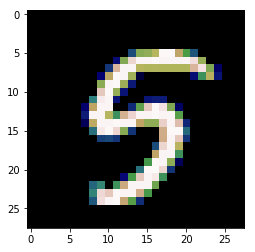

In [31]:
from PIL import Image
from matplotlib import cm
from matplotlib.pyplot import imshow
%matplotlib inline
im = Image.fromarray(np.uint8(cm.gist_earth(sample)*255))
imshow(im)

In [63]:
from sklearn.model_selection import train_test_split
labels = df['label'].values
labels, levels = pd.factorize(labels)
y = indices_to_one_hot(labels, nb_classes)
classes = len(np.unique(labels))
data = df.drop(columns=['label']).values
x_train, x_test, y_train, y_test = train_test_split(data,y, train_size=0.75)

In [64]:
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))
print("classes:", classes)
print(levels)

31500
10500
31500
10500
classes: 10
[1 0 4 7 3 5 8 9 2 6]


In [50]:
def indices_to_one_hot(data, nb_classes):
    """Convert an iterable of indices to one-hot encoded labels."""
    targets = np.array(data, dtype=np.int16).reshape(-1)
    return np.eye(nb_classes,dtype=np.int8)[targets]

In [68]:
print(y_train.shape)

(31500, 10)


In [85]:
EPOCHS = 10
BATCH_SIZE = 256

In [94]:
### Simple NN
from keras.layers import Dense, Input
from keras.models import Model

input_shape = x_train.shape[1]
output_shape = y_train.shape[1]

inputs = Input(shape=(input_shape,))
dense1 = Dense(units=1000, activation='sigmoid')(inputs)
dense2 = Dense(units=1000, activation='sigmoid')(dense1)
dense3 = Dense(units=1000, activation='sigmoid')(dense2)
output = Dense(units=output_shape, activation='softmax')(dense3)

model = Model(inputs=inputs, outputs=output)



In [109]:
from keras.optimizers import Adam


adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [110]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 1000)              785000    
_________________________________________________________________
dense_17 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_18 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_19 (Dense)             (None, 10)                10010     
Total params: 2,797,010
Trainable params: 2,797,010
Non-trainable params: 0
_________________________________________________________________
None


In [111]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint(path+'/weights.hdf5', monitor='val_acc', verbose=2,
                                     save_best_only=True, mode='auto')
early_stopping = EarlyStopping(monitor='val_loss',patience=6, verbose = 1)
reduceLR = ReduceLROnPlateau(monitor='val_loss',factor=0.33,patience=2,verbose = 1)

history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_data=(x_test, y_test), class_weight='auto')

Train on 31500 samples, validate on 10500 samples
Epoch 1/10
31500/31500 [==============================] - 2s 67us/step - loss: 0.1139 - acc: 0.9648 - val_loss: 0.1448 - val_acc: 0.9554
Epoch 2/10
31500/31500 [==============================] - 2s 50us/step - loss: 0.0944 - acc: 0.9715 - val_loss: 0.1426 - val_acc: 0.9568
Epoch 3/10
31500/31500 [==============================] - 2s 51us/step - loss: 0.0828 - acc: 0.9750 - val_loss: 0.1395 - val_acc: 0.9559
Epoch 4/10
31500/31500 [==============================] - 2s 51us/step - loss: 0.0763 - acc: 0.9770 - val_loss: 0.1383 - val_acc: 0.9586
Epoch 5/10
31500/31500 [==============================] - 2s 50us/step - loss: 0.0680 - acc: 0.9796 - val_loss: 0.1406 - val_acc: 0.9578
Epoch 6/10
31500/31500 [==============================] - 2s 50us/step - loss: 0.0630 - acc: 0.9810 - val_loss: 0.1347 - val_acc: 0.9588
Epoch 7/10
31500/31500 [==============================] - 2s 51us/step - loss: 0.0566 - acc: 0.9839 - val_loss: 0.1356 - val_acc

In [112]:
y_pred = model.predict(x_test)

In [113]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

[[1147    0    4    2    2    1    8    2    8    0]
 [   0 1021    3    0    0    4    7    2    4    6]
 [   0    0 1000    0    0    0    2   16    5    4]
 [   5    3    1 1016    3    2    3   11    9    0]
 [   3    0    0    3 1023   12    6    9   11    0]
 [   0    3    3    0   21  909   13   11    0    6]
 [   6    4    3    5   20    5  928   18    3    1]
 [   3    1   30   10    9    1    2  994    0    0]
 [   6    1    2    8    4    0    7    2 1048    1]
 [   5    4    6    0    1    7    5    1    2 1013]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1174
           1       0.98      0.98      0.98      1047
           2       0.95      0.97      0.96      1027
           3       0.97      0.96      0.97      1053
           4       0.94      0.96      0.95      1067
           5       0.97      0.94      0.95       966
           6       0.95      0.93      0.94       993
           7       0.93      0.95   